# 03  PyTorch Computer Vision
Link to lesson: https://www.learnpytorch.io/03_pytorch_computer_vision/

## Important Learnings
1. 

In [1]:
%load_ext autoreload
%autoreload 2

In [116]:
import os, time, sys, json, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets

from tqdm.auto import tqdm

## Important Learnings
1. PT recommends expressing images in the NHWC format instead of NCHW (N:Num. of images, C:Channels, H:Height, W:Width), because the stride of a tensor is much lesser in NHWC format and leads to faster runtimes of models : [https://pytorch.org/blog/tensor-memory-format-matters/#pytorch-best-practice]   
2. 

## Data
Working with FashionMNIST, directly available with torchvision.datasets  
Apparently parameters used in torchvision.datasets are similar to parameters given to other datasets objects in PT  
Building a dataloader on top of the dataset. Apparently on torch-defined datasets building a dataloader is zero-shot, i.e. absolutely no effort required.  

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    download=True,
    train=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    download=True,
    train=False,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
os.listdir("data/FashionMNIST/raw/")

['t10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 't10k-images-idx3-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 'train-labels-idx1-ubyte',
 't10k-labels-idx1-ubyte.gz']

In [5]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [6]:
len(train_data.data), len(train_data.targets)

(60000, 60000)

In [7]:
len(test_data.data), len(test_data.targets)

(10000, 10000)

In [8]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

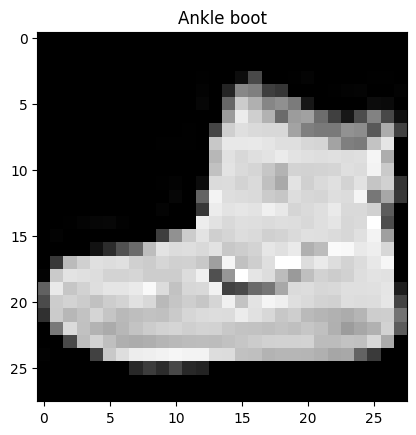

In [32]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.show()

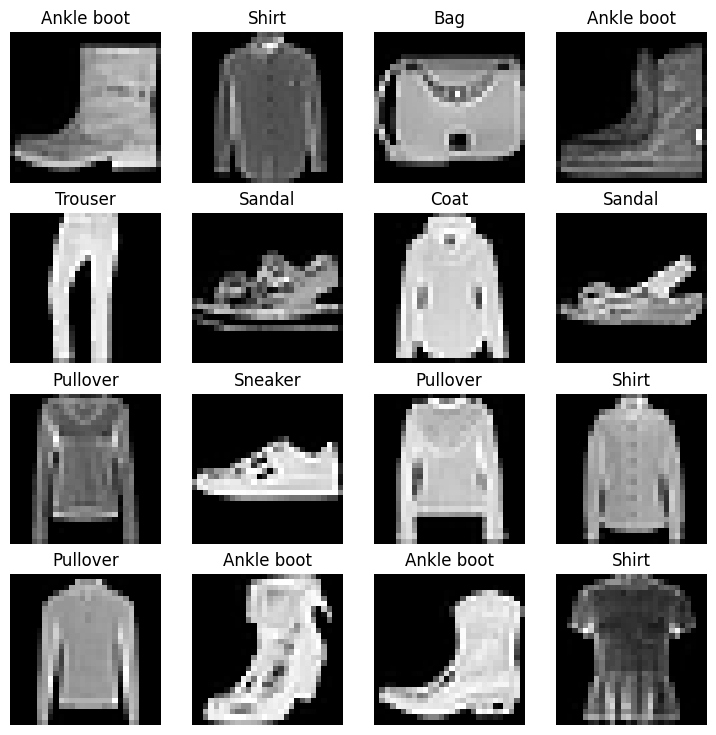

In [33]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)
    
plt.show()

In [9]:
BATCH_SIZE = 32

In [10]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [36]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Modeling
1. Flatten image tensors and build linear model without relu  
2. Same as above but with relu  
3. CNN - actual stuff for CV

In [11]:
class FashionModel0(nn.Module):
    
    def __init__(self, input_fts: int, hidden_fts: int, output_fts: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_fts, out_features=hidden_fts),
            nn.Linear(in_features=hidden_fts, out_features=output_fts)
        )
        
    def forward(self, x):
        return self.model(x)
    
    
class FashionModel1(nn.Module):
    
    def __init__(self, input_fts: int, hidden_fts: int, output_fts: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_fts, out_features=hidden_fts),
            nn.ReLU(),
            nn.Linear(in_features=hidden_fts, out_features=output_fts),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.model(x)

In [12]:
INPUT_SHAPE = 28*28
HIDDEN_DIM = 10
OUTPUT_SHAPE = len(class_names)

In [24]:
model0 = FashionModel0(INPUT_SHAPE, HIDDEN_DIM, OUTPUT_SHAPE)
model1 = FashionModel1(INPUT_SHAPE, HIDDEN_DIM, OUTPUT_SHAPE)

In [25]:
lossfn0, optimizer0 = nn.CrossEntropyLoss(), torch.optim.SGD(params=model0.parameters(), lr=1e-1)
lossfn1, optimizer1 = nn.CrossEntropyLoss(), torch.optim.SGD(params=model1.parameters(), lr=1e-1)

In [26]:
device = 'cpu'

In [27]:
def train(epoch, model, loader, lossfn, optimizer):
    
    model.to(device)
    model.train()
    train_loss = 0
    
    for i,(X,y) in enumerate(loader):
        
        X = X.to(device)
        y = y.to(device)
        
        y_pred = model(X)
        loss = lossfn(y_pred, y)
        train_loss+=loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch : {epoch} | Train Loss : {train_loss/len(loader)}")
    return train_loss/len(loader)

In [119]:
def validate(epoch, model, loader, lossfn):
    
    model.to(device)
    model.eval()
    eval_loss = 0
    
    with torch.inference_mode():
        for i, (X,y) in enumerate(loader, desc="evaluating"):

            X = X.to(device)
            y = y.to(device)
            
            y_pred = model(X)
            loss = lossfn(y_pred, y)
            eval_loss+=loss
        
    print(f"Epoch : {epoch} | Val Loss : {eval_loss/len(loader)}")
    return eval_loss/len(loader)

In [29]:
train_loss0, eval_loss0 = [], []
for epoch in range(5):
    train_loss0.append(train(epoch, model0, train_dataloader, lossfn0, optimizer0))
    eval_loss0.append(validate(epoch, model0, test_dataloader, lossfn0))

Epoch : 0 | Train Loss : 0.5877981781959534
Epoch : 0 | Val Loss : 0.5342839360237122
Epoch : 1 | Train Loss : 0.473746120929718
Epoch : 1 | Val Loss : 0.4811383783817291
Epoch : 2 | Train Loss : 0.454959511756897
Epoch : 2 | Val Loss : 0.4840286672115326
Epoch : 3 | Train Loss : 0.44221359491348267
Epoch : 3 | Val Loss : 0.47982820868492126
Epoch : 4 | Train Loss : 0.4359316825866699
Epoch : 4 | Val Loss : 0.46506720781326294


In [32]:
train_loss0, eval_loss0 = [t.item() for t in train_loss0], [e.item() for e in eval_loss0]

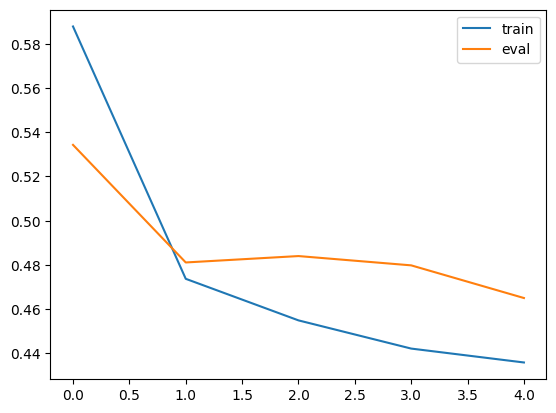

In [37]:
plt.plot(list(range(5)), train_loss0, label="train")
plt.plot(list(range(5)), eval_loss0, label="eval")
plt.legend()
plt.show()

In [39]:
train_loss1, eval_loss1 = [], []
for epoch in range(5):
    train_loss1.append(train(epoch, model1, train_dataloader, lossfn1, optimizer1).item())
    eval_loss1.append(validate(epoch, model1, test_dataloader, lossfn1))

Epoch : 0 | Train Loss : 0.6893023252487183
Epoch : 0 | Val Loss : 0.7083825469017029
Epoch : 1 | Train Loss : 0.47399184107780457
Epoch : 1 | Val Loss : 0.44449758529663086
Epoch : 2 | Train Loss : 0.43401074409484863
Epoch : 2 | Val Loss : 0.4709268808364868
Epoch : 3 | Train Loss : 0.4228259027004242
Epoch : 3 | Val Loss : 0.45408815145492554
Epoch : 4 | Train Loss : 0.41493722796440125
Epoch : 4 | Val Loss : 0.43016237020492554


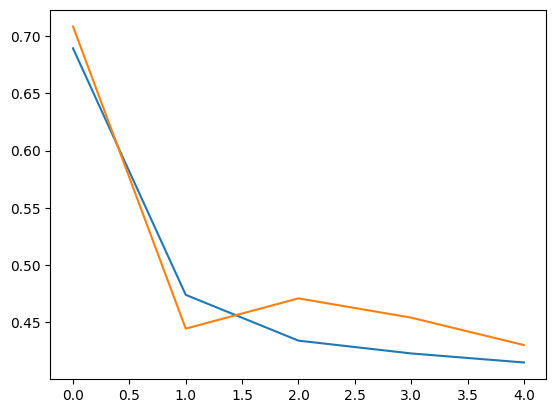

In [41]:
plt.plot(list(range(5)), train_loss1, label="train")
plt.plot(list(range(5)), eval_loss1, label="eval")
plt.show()

## CNN

In [55]:
class FashionModel2(nn.Module):
    
    def __init__(self, in_channels, hid_channels, out_channels):
        
        super().__init__()
        
        # Input shape here N,C,H,W
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=hid_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hid_channels,
                out_channels=hid_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        
        # Input shape here N,HidC,H//2,W//2
        self.block2 = nn.Sequential(
            nn.Conv2d(hid_channels, hid_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hid_channels, hid_channels, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        
        # Input shape here N,HidC,H//4,W//4
        # When this gets flattened: N, HidC*H//4*W//4
        # H,W = 28,28 initially - know this from the input data we're passing
        # If I want this to be generalized, I shouls consume the image input shape as a parameter to this init
        total_pixels = hid_channels*7*7
        self.block3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(total_pixels, out_channels)
        )
        
    def forward(self, X):
        
        return self.block3(self.block2(self.block1(X)))

In [56]:
image, label = next(iter(train_dataloader))

In [57]:
image.shape

torch.Size([32, 1, 28, 28])

In [58]:
model2 = FashionModel2(1, 5, len(class_names))

In [60]:
model2(image).shape

torch.Size([32, 10])

In [61]:
lossfn2, optimizer2 = nn.CrossEntropyLoss(), torch.optim.SGD(params=model2.parameters(), lr=1e-1)

In [62]:
train_loss2, eval_loss2 = [], []
for epoch in range(5):
    train_loss2.append(train(epoch, model2, train_dataloader, lossfn2, optimizer2).item())
    eval_loss2.append(validate(epoch, model2, test_dataloader, lossfn2))

Epoch : 0 | Train Loss : 0.8142592310905457
Epoch : 0 | Val Loss : 0.40735018253326416
Epoch : 1 | Train Loss : 0.38548678159713745
Epoch : 1 | Val Loss : 0.4126279652118683
Epoch : 2 | Train Loss : 0.35259440541267395
Epoch : 2 | Val Loss : 0.3619684875011444
Epoch : 3 | Train Loss : 0.33550721406936646
Epoch : 3 | Val Loss : 0.36556845903396606
Epoch : 4 | Train Loss : 0.3213821351528168
Epoch : 4 | Val Loss : 0.3459456264972687


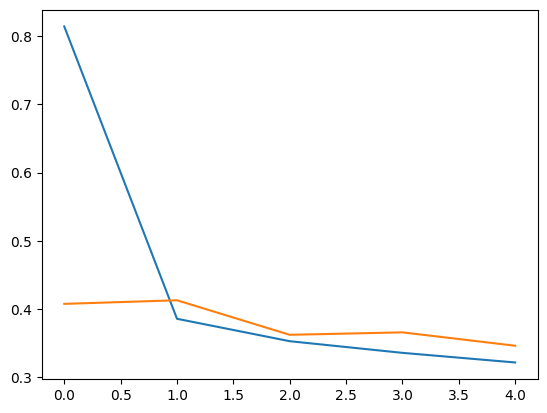

In [63]:
plt.plot(list(range(5)), train_loss2, label="train")
plt.plot(list(range(5)), eval_loss2, label="eval")
plt.show()

## Inference Functions
Creating a separate method to take care of inference only

In [135]:
# input expected is batch of images as tensors
def inference(model : torch.nn.Module, data : list, device : torch.device = 'cpu'):
    
    model.eval()
    model_inputs = torch.Tensor(data)
    model.to(device)
    model_inputs.to(device)
    
    with torch.inference_mode():
        
        pred_logits = model(model_inputs)
        print(pred_logits.shape)
        pred_probs = torch.softmax(pred_logits, dim=1).cpu()
        pred_labels = torch.argmax(pred_probs, dim=1).numpy()
        pred_labels = [class_names[i] for i in pred_labels]
        
    print(pred_probs.shape)
    return pred_labels, pred_probs

In [136]:
test_data.data[:100].shape

torch.Size([100, 28, 28])

In [137]:
xtest, ytest = next(iter(test_dataloader))

In [138]:
xtest.shape

torch.Size([32, 1, 28, 28])

In [139]:
labels, probs = inference(model2, xtest)

torch.Size([32, 10])
torch.Size([32, 10])


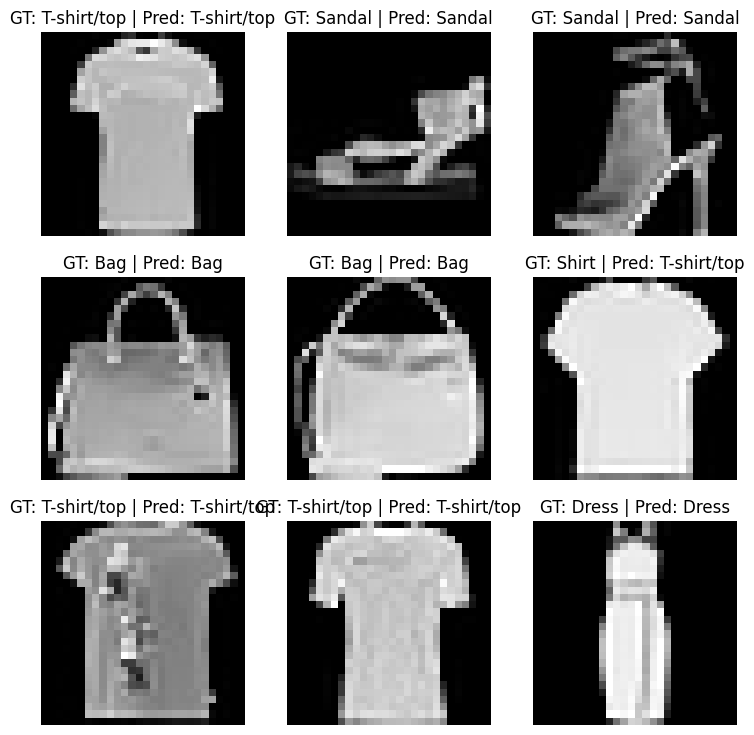

In [140]:
fig = plt.figure(figsize=(9,9))
rows,cols = 3,3
for i in range(1,10):
    img, label = xtest[i], class_names[ytest[i]]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"GT: {label} | Pred: {labels[i]}")
    plt.axis(False)
    
plt.show()

In [152]:
model2.eval()
preds, gt = [], []
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Predicting"):
        X, y = X.to(device), y.to(device)
        logits = model2(X)
        # shape is 32,10
        labels = torch.softmax(logits, dim=1).argmax(dim=1)
        preds.append(labels.cpu())
        gt.append(y.cpu())
preds = torch.cat(preds)
gt = torch.cat(gt)

Predicting:   0%|          | 0/313 [00:00<?, ?it/s]

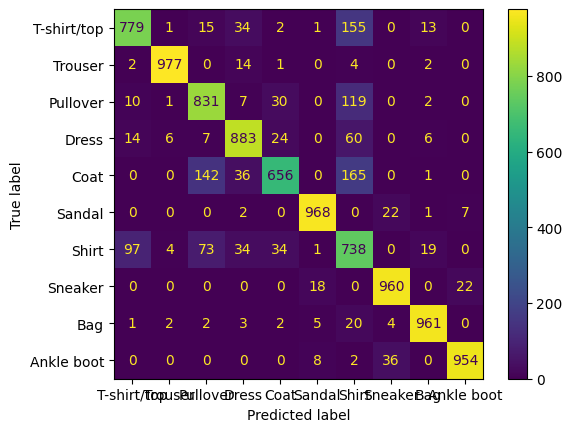

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(gt, preds)
d = ConfusionMatrixDisplay(cm, display_labels=class_names)
d.plot()
plt.show()